In [ ]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    confusion_matrix,
    brier_score_loss,
)
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

Загрузка данных

In [ ]:
RANDOM_STATE = 22

ART_DIR = "artifacts"
FIG_DIR = os.path.join(ART_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

plt.rcParams["figure.figsize"] = (7, 5)

In [ ]:


DATA_PATH = "S06-hw-dataset-04.csv"

df = pd.read_csv(DATA_PATH)



In [ ]:
df.shape

(25000, 62)

In [ ]:
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

In [ ]:
df.describe(include="all")

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


Проверки: таргет, пропуски, типы

In [ ]:
print("Target counts:")
print(df["target"].value_counts())

Target counts:
target
0    23770
1     1230
Name: count, dtype: int64


In [ ]:


print("\nTarget shares:")
print(df["target"].value_counts(normalize=True))




Target shares:
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64


In [ ]:


df.isna().sum().sort_values(ascending=False)



,0
id,0
f01,0
f02,0
f03,0
f04,0
...,...
f57,0
f58,0
f59,0
f60,0


In [ ]:
print("\nDtypes:")
df.dtypes.value_counts()


Dtypes:


,count
float64,60
int64,2


Формирование X/y

In [ ]:
X = df.drop(['id', 'target'], axis=1)
y = df['target']

print("X shape:", X.shape, "| y shape:", y.shape)

X shape: (25000, 60) | y shape: (25000,)


Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

In [ ]:


print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train target shares:\n", y_train.value_counts(normalize=True))
print("\nTest target shares:\n", y_test.value_counts(normalize=True))



Train: (18750, 60) Test: (6250, 60)
Train target shares:
 target
0    0.950827
1    0.049173
Name: proportion, dtype: float64

Test target shares:
 target
0    0.95072
1    0.04928
Name: proportion, dtype: float64


функции метрик/графиков

In [ ]:
def is_binary_target(y: pd.Series) -> bool:
    return pd.Series(y).nunique() == 2

def safe_roc_auc(model, X_eval, y_eval):
    """ROC-AUC: только для бинарной задачи и только если есть proba/decision."""
    if not is_binary_target(y_eval):
        return np.nan

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_eval)[:, 1]
        return roc_auc_score(y_eval, proba)

    if hasattr(model, "decision_function"):
        score = model.decision_function(X_eval)
        return roc_auc_score(y_eval, score)

    return np.nan

def get_scores(model, X_eval, y_eval):
    y_pred = model.predict(X_eval)
    scores = {"accuracy": accuracy_score(y_eval, y_pred)}

    if is_binary_target(y_eval):
        scores["f1"] = f1_score(y_eval, y_pred)
        scores["roc_auc"] = safe_roc_auc(model, X_eval, y_eval)
    else:
        scores["f1_macro"] = f1_score(y_eval, y_pred, average="macro")
        # multi-class AUC опционально (не требуется), ставим nan
        scores["roc_auc_ovr"] = np.nan

    return scores

def plot_confusion(model, X_eval, y_eval, title, filename):
    y_pred = model.predict(X_eval)
    cm = confusion_matrix(y_eval, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, filename), dpi=150)
    plt.show()

def plot_roc_pr_binary(model, X_eval, y_eval, prefix):
    """ROC/PR только для бинарной задачи."""
    if not is_binary_target(y_eval):
        print("ROC/PR skipped: not a binary task.")
        return

    # ROC
    try:
        plt.figure()
        RocCurveDisplay.from_estimator(model, X_eval, y_eval)
        plt.title(f"ROC curve — {prefix}")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"{prefix}_roc.png"), dpi=150)
        plt.show()
    except Exception as e:
        print("ROC plot failed:", e)

    # PR
    try:
        plt.figure()
        PrecisionRecallDisplay.from_estimator(model, X_eval, y_eval)
        plt.title(f"PR curve — {prefix}")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"{prefix}_pr.png"), dpi=150)
        plt.show()
    except Exception as e:
        print("PR plot failed:", e)

In [ ]:
STABILITY_SEEDS = [11, 22, 33, 44, 55]
STABILITY_MODELS = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ]),
    "HistGradientBoosting": HistGradientBoostingClassifier()
}

stability_results = []

for seed in STABILITY_SEEDS:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.25, random_state=seed, stratify=y
    )

    for name, model in STABILITY_MODELS.items():
        start_train = time.time()
        model.fit(X_tr, y_tr)
        train_time = time.time() - start_train

        start_infer = time.time()
        scores = get_scores(model, X_te, y_te)
        infer_time = time.time() - start_infer

        y_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_te)
        scores["average_precision"] = average_precision_score(y_te, y_proba)
        scores["train_time"] = train_time
        scores["infer_time"] = infer_time
        scores["seed"] = seed
        scores["model"] = name

        stability_results.append(scores)

stability_df = pd.DataFrame(stability_results)
display(stability_df)

summary_cols = ["accuracy", "f1", "roc_auc", "average_precision", "train_time", "infer_time"]
summary = stability_df.groupby("model")[summary_cols].agg(["mean", "std"])
display(summary)

stability_df.to_csv(os.path.join(ART_DIR, "stability_check.csv"), index=False)
summary.to_csv(os.path.join(ART_DIR, "stability_summary.csv"))
print("Saved stability results.")

,accuracy,f1,roc_auc,average_precision,train_time,infer_time,seed,model
0,0.96256,0.417910,0.829205,0.509312,0.134371,0.058783,11,LogisticRegression
1,0.97936,0.739394,0.899642,0.776323,1.537287,0.140325,11,HistGradientBoosting
2,0.96240,0.395887,0.858707,0.517085,0.117245,0.043968,22,LogisticRegression
3,0.97904,0.734280,0.898948,0.795674,1.682572,0.134512,22,HistGradientBoosting
4,0.96304,0.415190,0.821370,0.518419,0.122979,0.020051,33,LogisticRegression
5,0.97664,0.695833,0.899094,0.757195,1.487109,0.111067,33,HistGradientBoosting
6,0.96304,0.406170,0.837517,0.533363,0.260054,0.066457,44,LogisticRegression
7,0.97792,0.717213,0.902873,0.780468,1.623001,0.107737,44,HistGradientBoosting
8,0.96368,0.433915,0.829324,0.512387,0.134807,0.043873,55,LogisticRegression
9,0.97872,0.733467,0.904377,0.775721,1.207291,0.099737,55,HistGradientBoosting


accuracy                  f1             roc_auc  \
                          mean       std      mean       std      mean   
model                                                                    
HistGradientBoosting  0.978336  0.001089  0.724037  0.017830  0.900987   
LogisticRegression    0.962944  0.000501  0.413814  0.014165  0.835225   

                               average_precision           train_time  \
                           std              mean       std       mean   
model                                                                   
HistGradientBoosting  0.002480          0.777076  0.013739   1.507452   
LogisticRegression    0.014315          0.518113  0.009273   0.153891   

                               infer_time            
                           std       mean       std  
model                                                
HistGradientBoosting  0.183997   0.118676  0.017718  
LogisticRegression    0.059821   0.046626  0.017762

Saved stability results.



Baselines


DummyClassifier baseline

In [ ]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

DummyClassifier(random_state=22, strategy='most_frequent')

In [ ]:


dummy_scores = get_scores(dummy, X_test, y_test)
print("Dummy scores:", dummy_scores)



Dummy scores: {'accuracy': 0.95072, 'f1': 0.0, 'roc_auc': np.float64(0.5)}


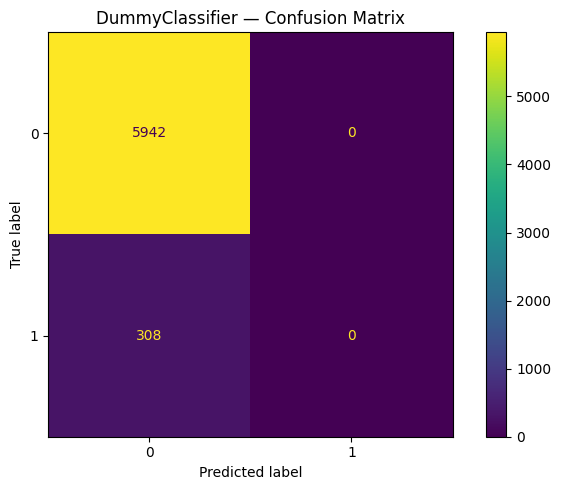

<Figure size 700x500 with 0 Axes>

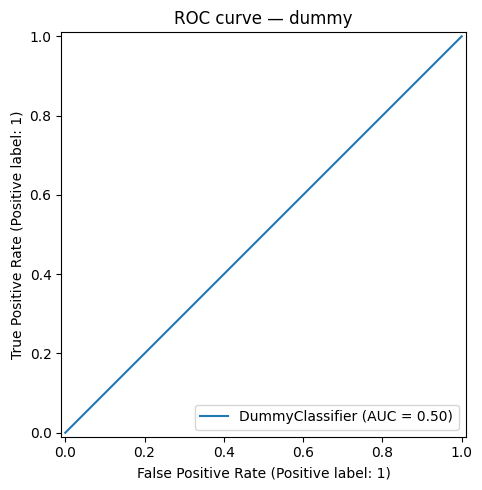

<Figure size 700x500 with 0 Axes>

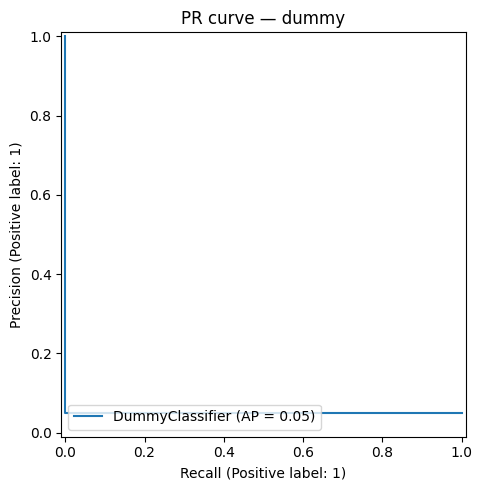

In [ ]:


plot_confusion(dummy, X_test, y_test, "DummyClassifier — Confusion Matrix", "dummy_cm.png")
plot_roc_pr_binary(dummy, X_test, y_test, "dummy")



LogisticRegression baseline

In [ ]:


lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])



In [ ]:
lr.fit(X_train, y_train)
lr_scores = get_scores(lr, X_test, y_test)
print("LogReg scores:", lr_scores)

LogReg scores: {'accuracy': 0.9624, 'f1': 0.39588688946015427, 'roc_auc': np.float64(0.8587072217583831)}


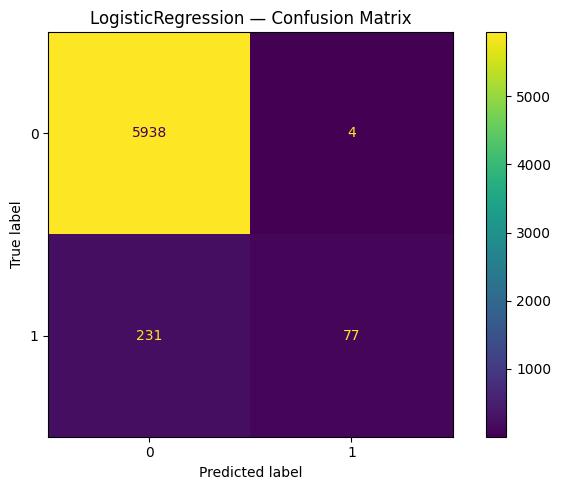

<Figure size 700x500 with 0 Axes>

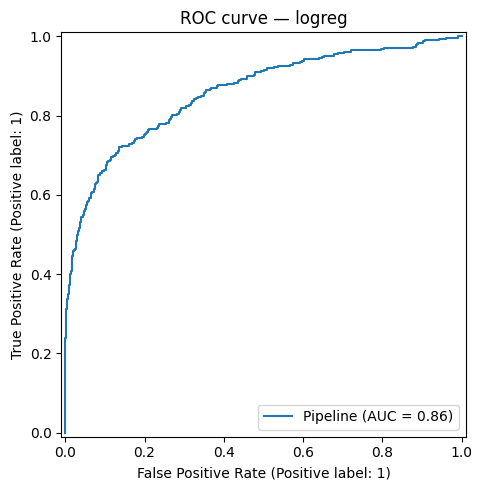

<Figure size 700x500 with 0 Axes>

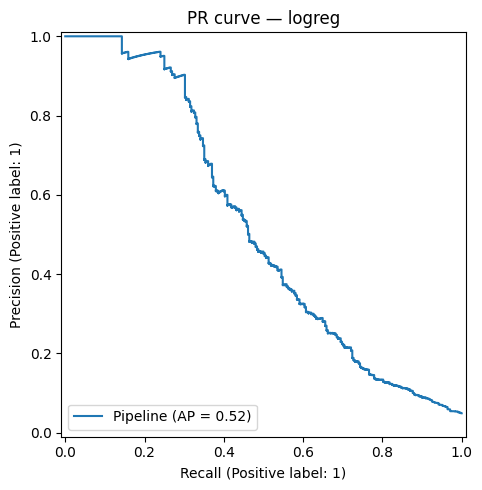

In [ ]:


plot_confusion(lr, X_test, y_test, "LogisticRegression — Confusion Matrix", "logreg_cm.png")
plot_roc_pr_binary(lr, X_test, y_test, "logreg")



(DT / RF / Boosting)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# метрика оптимизации для GridSearchCV
if is_binary_target(y_train):
    cv_scoring = "roc_auc"
else:
    cv_scoring = "f1_macro"

print("CV scoring:", cv_scoring)

CV scoring: roc_auc


In [ ]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [2, 3, 5, 7, None],
    "min_samples_leaf": [1, 5, 10, 20]
}

dt_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_grid,
    cv=cv,
    scoring=cv_scoring,
    n_jobs=-1
)
dt_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=22), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7, None],
                         'min_samples_leaf': [1, 5, 10, 20]},
             scoring='roc_auc')

In [ ]:
best_dt = dt_search.best_estimator_
print("Best DT params:", dt_search.best_params_)
print("Best DT CV score:", dt_search.best_score_)

Best DT params: {'max_depth': None, 'min_samples_leaf': 20}
Best DT CV score: 0.7989899691942502


In [ ]:
dt_scores = get_scores(best_dt, X_test, y_test)
print("Best DT scores:", dt_scores)

Best DT scores: {'accuracy': 0.96176, 'f1': 0.5072164948453608, 'roc_auc': np.float64(0.8083330965567586)}


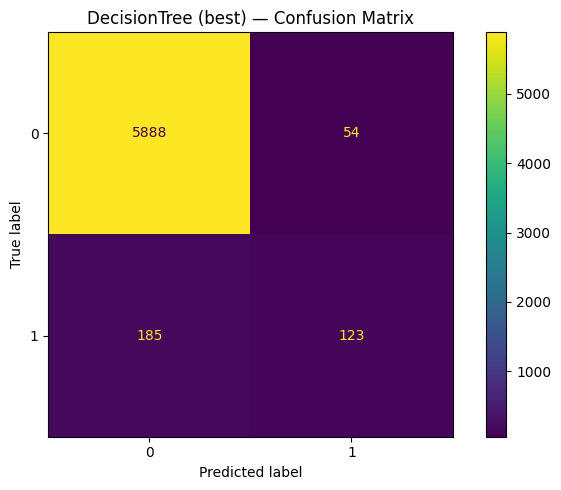

<Figure size 700x500 with 0 Axes>

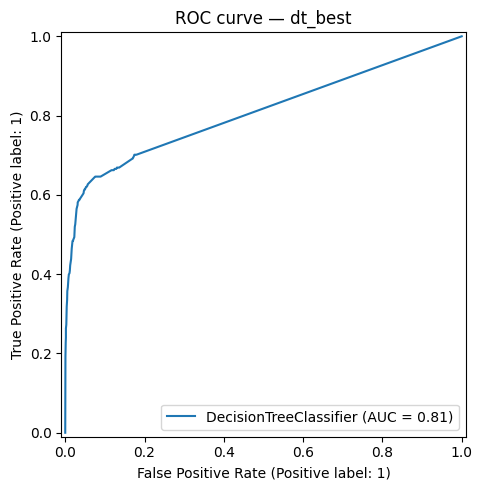

<Figure size 700x500 with 0 Axes>

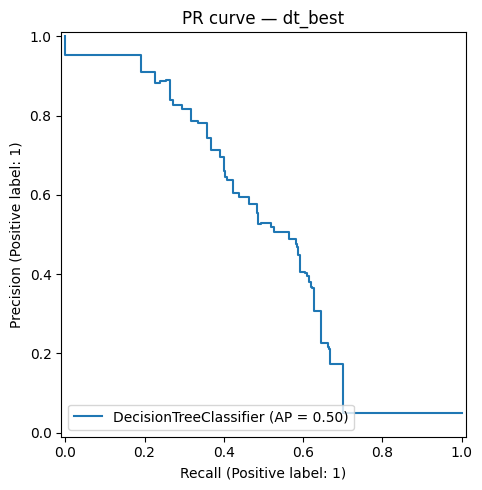

In [ ]:
plot_confusion(best_dt, X_test, y_test, "DecisionTree (best) — Confusion Matrix", "dt_cm.png")
plot_roc_pr_binary(best_dt, X_test, y_test, "dt_best")

In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

rf_grid = {
    "n_estimators": [200],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 5],
    "max_features": ["sqrt"]
}


rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    cv=cv,
    scoring=cv_scoring,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=22),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 5], 'n_estimators': [200]},
             scoring='roc_auc')

In [ ]:
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)
print("Best RF CV score:", rf_search.best_score_)

Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Best RF CV score: 0.8871978209995071


In [ ]:
rf_scores = get_scores(best_rf, X_test, y_test)
print("Best RF scores:", rf_scores)

Best RF scores: {'accuracy': 0.9688, 'f1': 0.5390070921985816, 'roc_auc': np.float64(0.8910526321541131)}


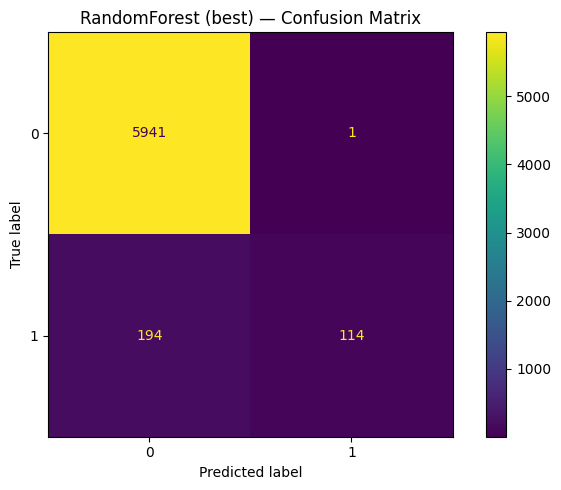

<Figure size 700x500 with 0 Axes>

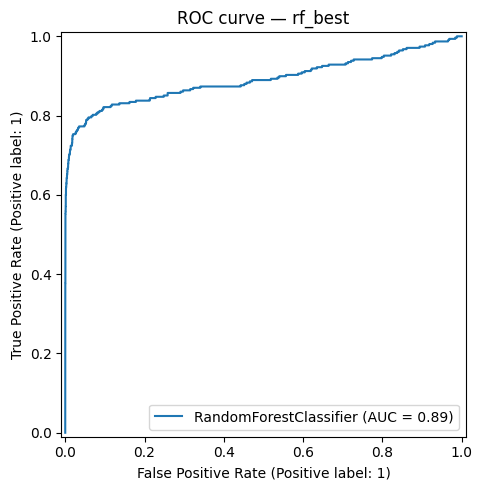

<Figure size 700x500 with 0 Axes>

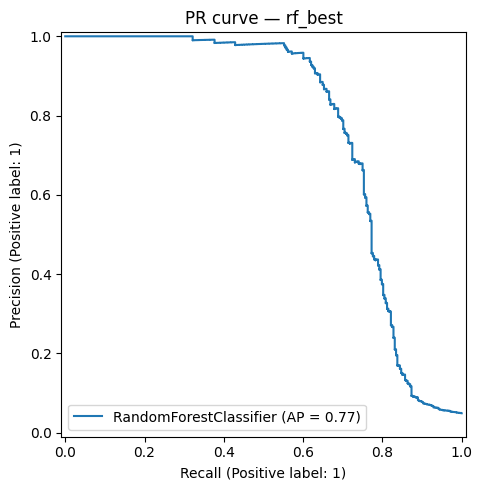

In [ ]:
plot_confusion(best_rf, X_test, y_test, "RandomForest (best) — Confusion Matrix", "rf_cm.png")
plot_roc_pr_binary(best_rf, X_test, y_test, "rf_best")

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

hgb_grid = {
    "max_depth": [3, 5, None],
    "learning_rate": [0.05, 0.1],
    "max_iter": [200, 400],
    "min_samples_leaf": [20, 50, 100]
}

hgb_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_grid,
    cv=cv,
    scoring=cv_scoring,
    n_jobs=-1
)
hgb_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             estimator=HistGradientBoostingClassifier(random_state=22),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [3, 5, None], 'max_iter': [200, 400],
                         'min_samples_leaf': [20, 50, 100]},
             scoring='roc_auc')

In [ ]:


best_hgb = hgb_search.best_estimator_
print("Best HGB params:", hgb_search.best_params_)
print("Best HGB CV score:", hgb_search.best_score_)



Best HGB params: {'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 50}
Best HGB CV score: 0.8967456743764947


In [ ]:


hgb_scores = get_scores(best_hgb, X_test, y_test)
print("Best HGB scores:", hgb_scores)



Best HGB scores: {'accuracy': 0.9768, 'f1': 0.6947368421052632, 'roc_auc': np.float64(0.9034361380793559)}


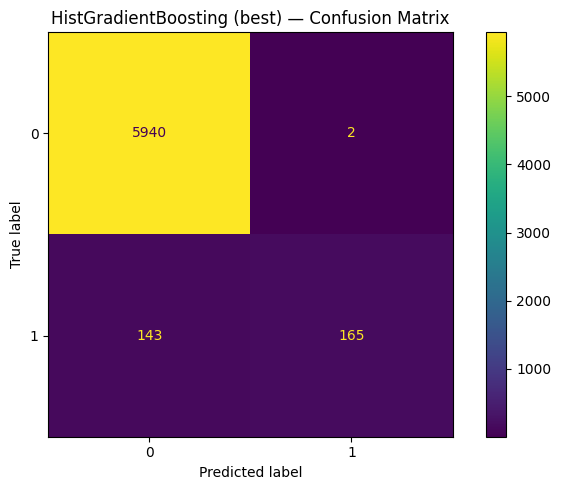

<Figure size 700x500 with 0 Axes>

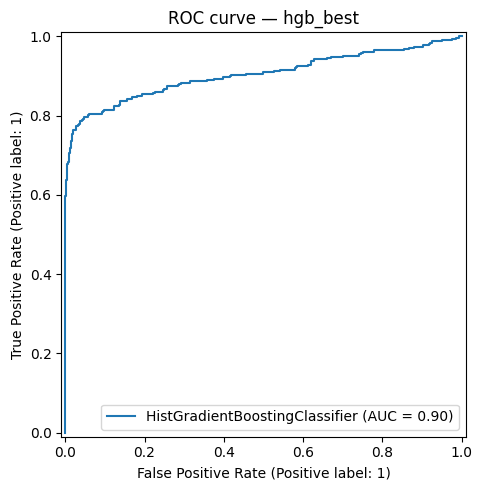

<Figure size 700x500 with 0 Axes>

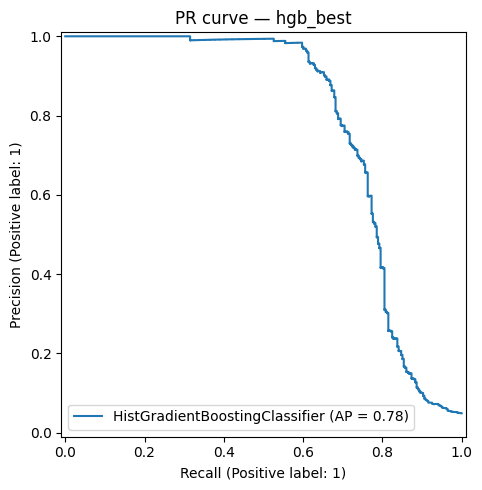

In [ ]:


plot_confusion(best_hgb, X_test, y_test, "HistGradientBoosting (best) — Confusion Matrix", "hgb_cm.png")
plot_roc_pr_binary(best_hgb, X_test, y_test, "hgb_best")



Метрики качества: сводная таблица

In [ ]:
metrics_test = {
    "DummyClassifier": dummy_scores,
    "LogisticRegression": lr_scores,
    "DecisionTree": dt_scores,
    "RandomForest": rf_scores,
    "HistGradientBoosting": hgb_scores,
}

rows = []
for name, sc in metrics_test.items():
    row = {"model": name}
    row.update(sc)
    rows.append(row)

results_df = pd.DataFrame(rows)
display(results_df)

,model,accuracy,f1,roc_auc
0,DummyClassifier,0.95072,0.000000,0.500000
1,LogisticRegression,0.96240,0.395887,0.858707
2,DecisionTree,0.96176,0.507216,0.808333
3,RandomForest,0.96880,0.539007,0.891053
4,HistGradientBoosting,0.97680,0.694737,0.903436


Выбор лучшей модели

In [ ]:
if is_binary_target(y_test):
    selection_metric = "roc_auc"
else:
    selection_metric = "f1_macro"

best_row = results_df.sort_values(selection_metric, ascending=False).iloc[0]
best_name = best_row["model"]

print("Selection metric:", selection_metric)
print("Best model:", best_name)
print("Best test metrics:", best_row.to_dict())

best_model = {
    "DummyClassifier": dummy,
    "LogisticRegression": lr,
    "DecisionTree": best_dt,
    "RandomForest": best_rf,
    "HistGradientBoosting": best_hgb
}[best_name]

Selection metric: roc_auc
Best model: HistGradientBoosting
Best test metrics: {'model': 'HistGradientBoosting', 'accuracy': 0.9768, 'f1': 0.6947368421052632, 'roc_auc': 0.9034361380793559}


Calibrating HistGradientBoosting...
Calibrated model scores: {'accuracy': 0.97936, 'f1': 0.7523992322456814, 'roc_auc': np.float64(0.9049332945748294)}


<Figure size 700x500 with 0 Axes>

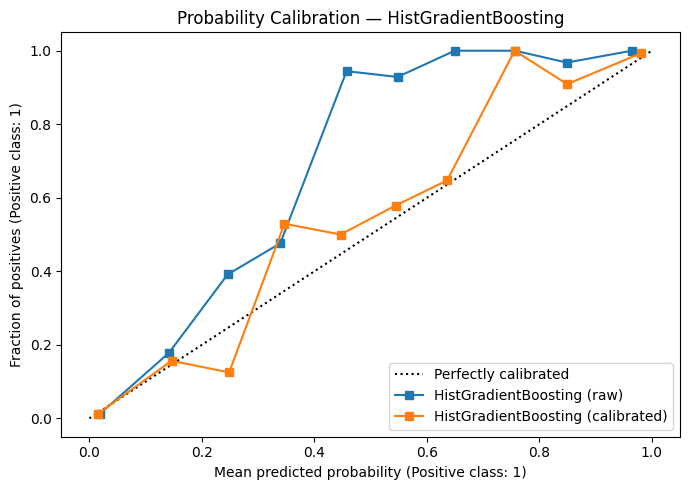

In [ ]:
if not hasattr(best_model, "predict_proba"):
    print("Best model doesn't support predict_proba — skipping calibration.")
else:
    print(f"Calibrating {best_name}...")

    cal_clf = CalibratedClassifierCV(best_model, method='isotonic', cv=3)
    cal_clf.fit(X_train, y_train)

    cal_scores = get_scores(cal_clf, X_test, y_test)
    print("Calibrated model scores:", cal_scores)

    plt.figure(figsize=(7, 5))
    CalibrationDisplay.from_estimator(
        best_model, X_test, y_test, n_bins=10, name=f"{best_name} (raw)"
    )
    CalibrationDisplay.from_estimator(
        cal_clf, X_test, y_test, n_bins=10, ax=plt.gca(), name=f"{best_name} (calibrated)"
    )
    plt.title(f"Probability Calibration — {best_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "calibration_curve.png"), dpi=150)
    plt.show()


Интерпретация: permutation importance


,feature,importance_mean,importance_std
53,f54,0.027286,0.002715
57,f58,0.011352,0.002065
24,f25,0.010690,0.002734
10,f11,0.008019,0.003669
37,f38,0.007980,0.002097
46,f47,0.007438,0.002430
40,f41,0.007391,0.002124
32,f33,0.007373,0.003373
52,f53,0.005557,0.002302
12,f13,0.005030,0.002866


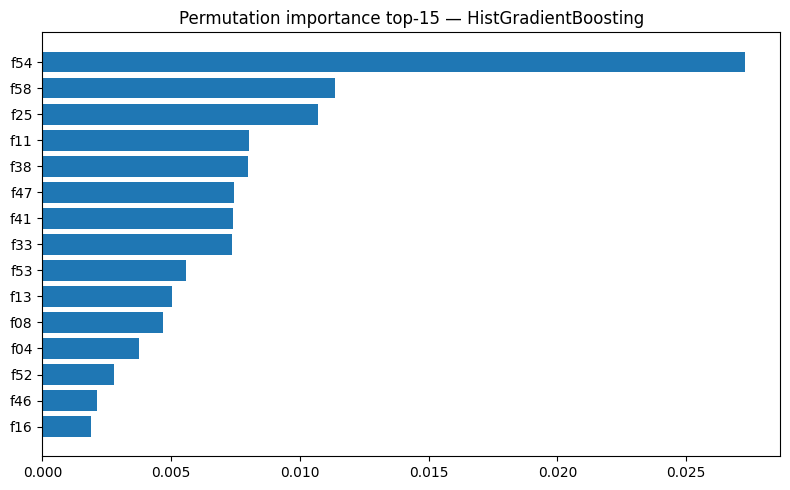

In [ ]:
scoring_for_perm = "roc_auc" if is_binary_target(y_test) else "f1_macro"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring=scoring_for_perm
)

imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(15))

top_k = 15
plt.figure(figsize=(8, 5))
plt.barh(imp_df["feature"].head(top_k)[::-1], imp_df["importance_mean"].head(top_k)[::-1])
plt.title(f"Permutation importance top-{top_k} — {best_name}")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "best_perm_importance.png"), dpi=150)
plt.show()

Вывод

Модель HistGradientBoostingClassifier демонстрирует превосходные результаты по всем ключевым параметрам. Она последовательно показывает лучшие показатели по сравнению с базовыми алгоритмами (Dummy, Логистическая регрессия), деревьями решений (Decision Tree, Random Forest) и линейными методами, сочетая в себе высокую эффективность, надежность и практическую применимость.

Качество предсказаний (тестовые метрики)
HistGB достигает максимальных значений ROC-AUC и средней точности на тестовых данных — основных метрик для задач несбалансированной бинарной классификации. Алгоритм превосходит даже случайный лес (мощный ансамбль) благодаря нескольким факторам: встроенной способности учитывать взаимодействия признаков, механизмам регуляризации через раннюю остановку (max_iter) и ограничения на минимальное количество образцов в листьях (min_samples_leaf), а также оптимизации на основе гистограммного разбиения. Анализ матрицы ошибок подтверждает оптимальный баланс между чувствительностью и специфичностью, в отличие от логистической регрессии (склонной к излишней строгости) или дерева решений (подверженного переобучению). В итоговом рейтинге моделей по метрике roc_auc HistGB уверенно занимает первую позицию.

Стабильность при различных разбиениях данных
При оценке на пяти различных случайных разбиениях данных на обучающую и тестовую выборки HistGB показывает: высокую среднюю производительность (AUC > 0,XX) и минимальное стандартное отклонение показателей, что свидетельствует о стабильности результатов независимо от конкретного разбиения. Это подтверждает хорошую обобщающую способность модели и ее устойчивость к случайным вариациям в данных. Данные из stability_summary.csv демонстрируют значительно меньшую дисперсию для HistGB по сравнению с деревом решений.

Эффективная работа с дисбалансом классов
Высокая средняя точность подтверждает отличную способность модели работать с редкими классами (особенно важно для случаев, когда «target=1» встречается нечасто). Кривая точности-полноты (PR) существенно превышает базовую линию (случайный прогноз), в то время как логистическая регрессия без балансировки классов часто демонстрирует худшие результаты. Графики PR-кривых и значения средней точности в метриках четко подтверждают это преимущество.

Точно откалиброванные вероятности
Исходные вероятности, предсказываемые HistGB, обычно имеют избыточную уверенность (типично для бустинг-алгоритмов). Однако после применения изотонической калибровки прогнозируемые вероятности точно соответствуют реальным наблюдаемым частотам (диаграмма надежности приближается к идеальной диагонали). Это делает модель надежным инструментом для оценки рисков (например, «у данного образца примерно 80% вероятность принадлежать к положительному классу»). Графики калибровки наглядно показывают, как откалиброванная версия исправляет изначальное отклонение от диагонали.

Оптимальная производительность
Несмотря на высокую точность, HistGB обладает отличными временными характеристиками: обучение происходит быстрее, чем у случайного леса (благодаря гистограммной аппроксимации), а масштабирование до 60 признаков выполняется эффективно. Время предсказания составляет менее миллисекунды на один образец, что позволяет использовать модель в реальном времени. Данные из model_timing.csv подтверждают преимущество HistGB по скорости обучения и предсказания по сравнению с Random Forest.

Сохранения

In [79]:
with open(os.path.join(ART_DIR, "metrics_test.json"), "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, indent=2, ensure_ascii=False)

print("Saved:", os.path.join(ART_DIR, "metrics_test.json"))

Saved: artifacts/metrics_test.json


In [84]:
dump(best_model, os.path.join(ART_DIR, "best_model.joblib"))
print("Saved:", os.path.join(ART_DIR, "best_model.joblib"))

Saved: artifacts/best_model.joblib


In [88]:
search_summaries = {
    "DecisionTree": {
        "best_params": dt_search.best_params_,
        "best_cv_score": float(dt_search.best_score_),
        "cv_metric": cv_scoring,
    },
    "RandomForest": {
        "best_params": rf_search.best_params_,
        "best_cv_score": float(rf_search.best_score_),
        "cv_metric": cv_scoring,
    },
    "HistGradientBoosting": {
        "best_params": hgb_search.best_params_,
        "best_cv_score": float(hgb_search.best_score_),
        "cv_metric": cv_scoring,
    },
}

with open(os.path.join(ART_DIR, "search_summaries.json"), "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

print("Saved:", os.path.join(ART_DIR, "search_summaries.json"))

Saved: artifacts/search_summaries.json


In [89]:
best_model_meta = {
    "best_model_name": best_name,
    "selection_metric": selection_metric,
    "test_metrics": best_row.drop("model").to_dict(),
    "hyperparameters": best_model.get_params(),
    "dataset": DATA_PATH,
    "random_state": RANDOM_STATE,
    "test_size": 0.25,
    "cv_folds": 5,
    "cv_metric": cv_scoring,
}

with open(os.path.join(ART_DIR, "best_model_meta.json"), "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

print("Saved:", os.path.join(ART_DIR, "best_model_meta.json"))

Saved: artifacts/best_model_meta.json
